# Data 620 - Project 3
Baron Curtin, Heather Geiger, Mikhail Groysman, Betsy Rosalen 

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python,
and any features you can think of, build the best name gender classifier you can.

Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the devtest set, and the remaining 6900 words for the training set. Then, starting with the example name gender
classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are
satisfied with your classifier, check its final performance on the test set.

How does the performance on the test set compare to the performance on the dev-test set? Is this what
you'd expect? 

In [1]:
# library imports
import random
import re
from collections import Counter
from nltk import download
from nltk.corpus import names
from nltk.util import ngrams
from nltk.tokenize.sonority_sequencing import SyllableTokenizer
from nltk import NaiveBayesClassifier
from nltk import DecisionTreeClassifier
from nltk import classify
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

# jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Data Loading/Preparation
In the following cells, we will be loading the corpus into memory, labelling all of the names, and then randomizing the
list of names for later use. Randomizing the names will ensure that our training/test sets will contain both genders from 
which we should be able to create numerous features from.

In [2]:
# read in names from the files
# label each name with corresponding gender
# names to be lowercase for easy recognition 
download('names')
males = [(name.lower().strip(), 'male') for name in names.words('male.txt')]
females = [(name.lower().strip(), 'female') for name in names.words('female.txt')]

# combine lists of names
all_names = males + females

# randomize the list
random.shuffle(all_names)

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\Maintenance\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


True

## Feature Creation
Features are the most important part of what goes into a machine learning model. For that reason, it is critically important
to try to come up with features that make the most sense in identifying gender differences in names. To make creation and analysis easier,
we will put our data in a Pandas dataframe.

In [3]:
# create dataframe
data = pd.DataFrame.from_dict(dict(all_names), orient='index', columns=['gender']).reset_index()
data.columns = ['name', 'gender']
data.head()

,name,gender
0,zsa zsa,female
1,jean-luc,male
2,tomas,male
3,peggie,female
4,cleopatra,female


In [4]:
# instatiate syllable tokenize
SSP = SyllableTokenizer()

# create various feature columns for exploration
data['length'] = data['name'].str.len()
data['first_letter'] = data['name'].str[0]
data['last_letter'] = data['name'].str[-1]
data['vowel_last_letter'] = data['last_letter'].isin([*'aeiou'])
data['vowel_first_letter'] = data['first_letter'].isin([*'aeiou'])
data['vowels'] = data['name'].str.replace(r'[^aeiou]', '')
data['consonants'] = data['name'].str.replace(r'[aeiou]', '')
data['vowel_count'] = data['vowels'].str.len()
data['consonant_count'] = data['consonants'].str.len()
data['bigrams'] = data['name'].apply(lambda x: list(ngrams(x, 2)))
data['trigrams'] = data['name'].apply(lambda x: list(ngrams(x, 3)))
data['syllables'] = data['name'].apply(lambda x: len(SSP.tokenize(x)))

# preview data
data.head()

C:\ProgramData\Anaconda3\lib\site-packages\nltk\tokenize\sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))


,name,gender,length,first_letter,last_letter,vowel_last_letter,vowel_first_letter,vowels,consonants,vowel_count,consonant_count,bigrams,trigrams,syllables
0,zsa zsa,female,7,z,a,True,False,aa,zs zs,2,5,"[(z, s), (s, a), (a, ), ( , z), (z, s), (s, a)]","[(z, s, a), (s, a, ), (a, , z), ( , z, s), (...",2
1,jean-luc,male,8,j,c,False,False,eau,jn-lc,3,5,"[(j, e), (e, a), (a, n), (n, -), (-, l), (l, u...","[(j, e, a), (e, a, n), (a, n, -), (n, -, l), (...",3
2,tomas,male,5,t,s,False,False,oa,tms,2,3,"[(t, o), (o, m), (m, a), (a, s)]","[(t, o, m), (o, m, a), (m, a, s)]",2
3,peggie,female,6,p,e,True,False,eie,pgg,3,3,"[(p, e), (e, g), (g, g), (g, i), (i, e)]","[(p, e, g), (e, g, g), (g, g, i), (g, i, e)]",2
4,cleopatra,female,9,c,a,True,False,eoaa,clptr,4,5,"[(c, l), (l, e), (e, o), (o, p), (p, a), (a, t...","[(c, l, e), (l, e, o), (e, o, p), (o, p, a), (...",3


In [5]:
# lets analyze our bigrams and trigrams columns to get the most common ngrams by gender
ngrams_gender = data.groupby('gender')[['bigrams', 'trigrams']].sum()
ngrams_gender['bigrams_counter'] = ngrams_gender['bigrams'].apply(lambda x: Counter(x))
ngrams_gender['trigrams_counter'] = ngrams_gender['trigrams'].apply(lambda x: Counter(x))
ngrams_gender

,bigrams,trigrams,bigrams_counter,trigrams_counter
gender,,,,
female,"[(z, s), (s, a), (a, ), ( , z), (z, s), (s, a...","[(z, s, a), (s, a, ), (a, , z), ( , z, s), (...","{('z', 's'): 4, ('s', 'a'): 205, ('a', ' '): 1...","{('z', 's', 'a'): 4, ('s', 'a', ' '): 1, ('a',..."
male,"[(j, e), (e, a), (a, n), (n, -), (-, l), (l, u...","[(j, e, a), (e, a, n), (a, n, -), (n, -, l), (...","{('j', 'e'): 50, ('e', 'a'): 41, ('a', 'n'): 3...","{('j', 'e', 'a'): 7, ('e', 'a', 'n'): 10, ('a'..."


Using the counter class and the bigrams and trigrams, we can eliminate the need for the most common bigram/trigram and instead
just use the list of bigrams and trigrams as features. The most common bigram was only in ~13% of the female names and ~12%
of the male names.

## Data Exploration
Lets get a better feel for how our data is composed. In this exploration step, we will confirm whether any of the features
we created will become good predictors of gender. Exploration will occur both visually as well as computationally.

In [6]:
# use our created variables to generate some summary statistics
data.groupby('gender').mean()

,length,vowel_last_letter,vowel_first_letter,vowel_count,consonant_count,syllables
gender,,,,,,
female,6.149183,0.721498,0.174633,2.673909,3.475274,2.474447
male,5.941284,0.237783,0.154632,2.204230,3.737053,2.048140


In [7]:
# separate features from label
X = data.drop(columns=['name', 'gender'])
y = data['gender']

Based on the above chart, we see that females have a higher name length on average, higher vowel counts, and the last letter is 72% of the time a vowel.
These appear to be good predictors. We need to visual confirm what we see numerically

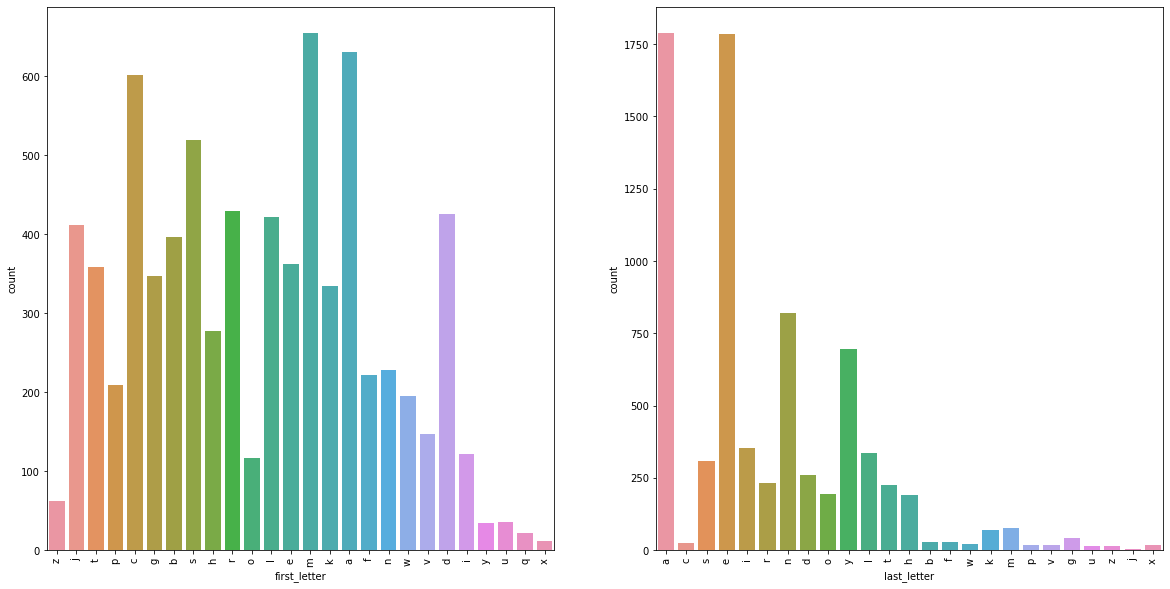

In [8]:
# categorical/numerical columns
categorical_cols = X.loc[:, [col for col in X.columns if 'gram' not in col]].select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=np.number).columns

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

for var, subplot in zip(categorical_cols[:2], ax.flatten()):
    sns.countplot(x=var, data=data, ax=subplot)
    # rotate labels for easy viewing
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

The distributions above don't tell us much. We need to condition on gender.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


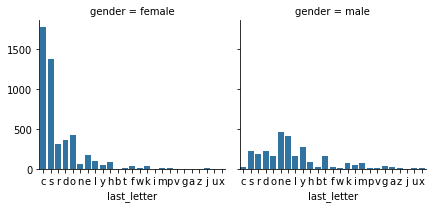

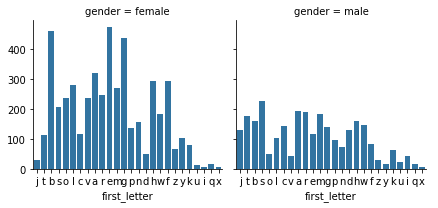

In [9]:
cond_plot = sns.FacetGrid(data=data, col='gender')
cond_plot.map(sns.countplot, 'last_letter').add_legend()
plt.tight_layout()
plt.show()

cond_plot = sns.FacetGrid(data=data, col='gender')
cond_plot.map(sns.countplot, 'first_letter').add_legend()
plt.tight_layout()
plt.show()

It would appear that both the first and the last letter could be pretty good predictors for gender.

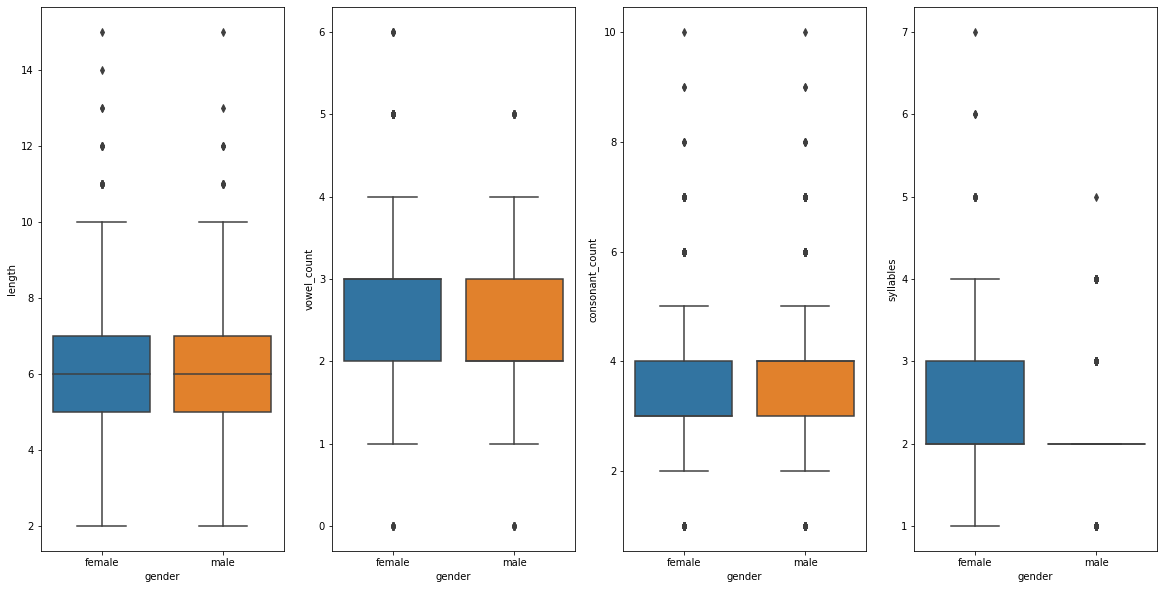

In [10]:
# numerical columns to gender exploration
fig, ax = plt.subplots(1, 4, figsize=(20, 10))

for var, subplot in zip(numerical_cols, ax.flatten()):
    sns.boxplot(x='gender', y=var, data=data, ax=subplot)
    

From the boxplots above, we can safely rule out vowel count, consonant count, and length as strong predictors of gender.  Syllables, however, seems like it may be a good predictor.

### Feature Generation Function
This function will be applied to our lists of names to create the features that we identified as potential predictors above in our initial model "kitchen sink" approach.  As we refine the model we will also refine this function to include only the features that seem most relevant to our classifier.  Vowel count, consonant count, and length have already been removed since they were found above to have no predictive value.  

In [11]:
# feature generator
def gender_features(name):
    
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    # vowels/consonants
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
    
    # bigrams/trigrams
    bigrams = (ngrams(name, 2))
    trigrams = (ngrams(name, 3))
    
    # syllables
    syllables = len(SSP.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        'consonants': consonants,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

## Data Preparation
We need to apply our feature generation function to our list of names and then split the lists into training, test, and validation sets.

In [12]:
# apply feature generation function
names = [(gender_features(name), gender) for name, gender in all_names]

# create each set of data
dev_set = names[:1000]
test = names[-6900:]

# split the development set into initial training and test sets
train = dev_set[:500]
dev_test = dev_set[500:]

C:\ProgramData\Anaconda3\lib\site-packages\nltk\tokenize\sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))


## Decision Tree

In [13]:
# create each set of data
dev_set_names = all_names[:2000]
test_names = all_names[2000:]

# split the development set into initial training and test sets
train_names = dev_set_names[:500]
devtest_names = dev_set_names[500:]

# apply feature generation function
test_set = [(gender_features(name), gender) for name, gender in test_names]
train_set = [(gender_features(name), gender) for name, gender in train_names]
devtest_set = [(gender_features(name), gender) for name, gender in devtest_names]

In [14]:
train_set[:2]

[({'first_letter': 'z',
   'vowel_first_letter': False,
   'last_letter': 'a',
   'vowel_last_letter': True,
   'vowels': 'a',
   'consonants': ' sz',
   'bigrams': <generator object ngrams at 0x00000262EBA16CC8>,
   'trigrams': <generator object ngrams at 0x00000262EBA16D48>,
   'syllables': 2},
  'female'),
 ({'first_letter': 'j',
   'vowel_first_letter': False,
   'last_letter': 'c',
   'vowel_last_letter': False,
   'vowels': 'aeu',
   'consonants': '-cjln',
   'bigrams': <generator object ngrams at 0x00000262EBA16E48>,
   'trigrams': <generator object ngrams at 0x00000262EBA16DC8>,
   'syllables': 3},
  'male')]

In [15]:
classifier = DecisionTreeClassifier.train(test_set)

In [16]:
'Accuracy: %4.2f' % classify.accuracy(classifier, devtest_set)

'Accuracy: 0.61'

In [17]:
errors = []
for (name, tag) in devtest_names:
    guess = classifier.classify(gender_features(name))
    if guess != tag:
        errors.append((tag, guess, name))
        
for (tag, guess, features) in sorted(errors):
    print('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, features))

correct=male     guess=female   name=abbott                        
correct=male     guess=female   name=abdulkarim                    
correct=male     guess=female   name=abdullah                      
correct=male     guess=female   name=abel                          
correct=male     guess=female   name=abner                         
correct=male     guess=female   name=abram                         
correct=male     guess=female   name=aditya                        
correct=male     guess=female   name=adolfo                        
correct=male     guess=female   name=adolph                        
correct=male     guess=female   name=adolphe                       
correct=male     guess=female   name=adolpho                       
correct=male     guess=female   name=adolphus                      
correct=male     guess=female   name=adrien                        
correct=male     guess=female   name=aguste                        
correct=male     guess=female   name=alaa       

### Refine features first try...

Remove Bigrams and Trigrams.  Add last two letters.  Remove Last Letter.

In [18]:
# feature generator
def gender_features2(name):
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    # last two letters
    last_two = name[-2:]
    
    # vowel/consonants + counts
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
    
    # syllables
    syllables = len(SSP.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'vowel_last_letter': vowel_last_letter,
        'last_two': last_two,
        'vowels': vowels,
        'consonants': consonants,
        'syllables': syllables
    }

In [19]:
# shuffle the dev_set_names to get a new split
random.shuffle(dev_set_names)

# split the development set into training and test sets
train_names = dev_set_names[:500]
devtest_names = dev_set_names[500:]

# apply feature generation function
test_set = [(gender_features2(name), gender) for name, gender in test_names]
train_set = [(gender_features2(name), gender) for name, gender in train_names]
devtest_set = [(gender_features2(name), gender) for name, gender in devtest_names]

In [20]:
classifier = DecisionTreeClassifier.train(train_set)

In [21]:
'Accuracy: %4.2f' % classify.accuracy(classifier, devtest_set)

'Accuracy: 0.56'

In [22]:
errors = []
for (name, tag) in devtest_names:
    guess = classifier.classify(gender_features2(name))
    if guess != tag:
        errors.append((tag, guess, name))
        
for (tag, guess, features) in sorted(errors):
    print('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, features))

correct=female   guess=male     name=acacia                        
correct=female   guess=male     name=adore                         
correct=female   guess=male     name=aggi                          
correct=female   guess=male     name=agnesse                       
correct=female   guess=male     name=agretha                       
correct=female   guess=male     name=ailee                         
correct=female   guess=male     name=alexandrina                   
correct=female   guess=male     name=alexis                        
correct=female   guess=male     name=alfie                         
correct=female   guess=male     name=alix                          
correct=female   guess=male     name=alpa                          
correct=female   guess=male     name=alyda                         
correct=female   guess=male     name=amalea                        
correct=female   guess=male     name=amara                         
correct=female   guess=male     name=amargo     

In [23]:
print(classifier.pseudocode(depth=4))

if consonants == '-hmrst': return 'female'
if consonants == 'b': 
  if vowels == 'ae': return 'female'
  if vowels == 'au': return 'male'
  if vowels == 'eio': return 'male'
if consonants == 'bcdkr': return 'male'
if consonants == 'bcdnt': return 'female'
if consonants == 'bchln': return 'female'
if consonants == 'bchlrst': return 'female'
if consonants == 'bck': return 'female'
if consonants == 'bcy': return 'male'
if consonants == 'bdhl': return 'male'
if consonants == 'bdlt': return 'male'
if consonants == 'bdnr': return 'male'
if consonants == 'bdr': return 'male'
if consonants == 'bdry': return 'female'
if consonants == 'bdz': return 'male'
if consonants == 'bgl': return 'female'
if consonants == 'bhlprt': return 'male'
if consonants == 'bhlst': return 'female'
if consonants == 'bhns': return 'female'
if consonants == 'bhnt': return 'female'
if consonants == 'bhsy': return 'male'
if consonants == 'bkrs': return 'male'
if consonants == 'bkry': return 'female'
if consonants == 'bl':

### Refine features second try...

Remove last_letter, vowels, consonants and syllables

In [55]:
# feature generator
def gender_features3(name):
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    # last two letters
    last_two = name[-2:]
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'vowel_last_letter': vowel_last_letter,
        'last_two': last_two
    }

In [56]:
# shuffle the dev_set_names to get a new split
random.shuffle(dev_set_names)

# split the development set into training and test sets
train_names = dev_set_names[:500]
devtest_names = dev_set_names[500:]

# apply feature generation function
test_set = [(gender_features3(name), gender) for name, gender in test_names]
train_set = [(gender_features3(name), gender) for name, gender in train_names]
devtest_set = [(gender_features3(name), gender) for name, gender in devtest_names]

In [57]:
classifier = DecisionTreeClassifier.train(train_set)

In [58]:
'Accuracy: %4.2f' % classify.accuracy(classifier, devtest_set)

'Accuracy: 0.70'

In [59]:
errors = []
for (name, tag) in devtest_names:
    guess = classifier.classify(gender_features3(name))
    if guess != tag:
        errors.append((tag, guess, name))
        
for (tag, guess, features) in sorted(errors):
    print('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, features))

correct=female   guess=male     name=abbe                          
correct=female   guess=male     name=abigail                       
correct=female   guess=male     name=agnesse                       
correct=female   guess=male     name=ainsley                       
correct=female   guess=male     name=alexis                        
correct=female   guess=male     name=allyce                        
correct=female   guess=male     name=aloise                        
correct=female   guess=male     name=amandie                       
correct=female   guess=male     name=anais                         
correct=female   guess=male     name=anett                         
correct=female   guess=male     name=ann-marie                     
correct=female   guess=male     name=annabal                       
correct=female   guess=male     name=annalyse                      
correct=female   guess=male     name=annamarie                     
correct=female   guess=male     name=anne-marie 

In [60]:
print(classifier.pseudocode(depth=4))

if last_two == 'ad': return 'male'
if last_two == 'ah': return 'female'
if last_two == 'al': 
  if first_letter == 'k': return 'female'
  if first_letter == 'm': return 'male'
  if first_letter == 'v': return 'male'
if last_two == 'am': 
  if first_letter == 'a': return 'male'
  if first_letter == 'b': return 'male'
  if first_letter == 'c': return 'female'
  if first_letter == 'm': return 'female'
if last_two == 'an': 
  if first_letter == 'd': return 'male'
  if first_letter == 'g': return 'female'
  if first_letter == 'j': return 'male'
  if first_letter == 'm': return 'female'
  if first_letter == 'n': return 'female'
  if first_letter == 's': return 'male'
  if first_letter == 'z': return 'male'
if last_two == 'as': return 'male'
if last_two == 'at': return 'male'
if last_two == 'av': return 'male'
if last_two == 'aw': return 'male'
if last_two == 'ay': 
  if first_letter == 'c': return 'male'
  if first_letter == 't': return 'female'
if last_two == 'be': return 'male'
if last_two

### Refine features third try...

Put bigrams and trigrams back in?

In [36]:
# feature generator
def gender_features4(name):
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    # last two letters
    last_two = name[-2:]
        
    # bigrams/trigrams
    bigrams = (ngrams(name, 2))
    trigrams = (ngrams(name, 3))
       
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'vowel_last_letter': vowel_last_letter,
        'last_two': last_two,
        'bigrams': bigrams,
        'trigrams': trigrams
    }

In [37]:
# shuffle the dev_set_names to get a new split
random.shuffle(dev_set_names)

# split the development set into training and test sets
train_names = dev_set_names[:500]
devtest_names = dev_set_names[500:]

# apply feature generation function
test_set = [(gender_features4(name), gender) for name, gender in test_names]
train_set = [(gender_features4(name), gender) for name, gender in train_names]
devtest_set = [(gender_features4(name), gender) for name, gender in devtest_names]

In [38]:
classifier = DecisionTreeClassifier.train(train_set)

In [39]:
'Accuracy: %4.2f' % classify.accuracy(classifier, devtest_set)

'Accuracy: 0.62'